### Setup Environment

In [1]:
Project_Root = '/gdrive/MyDrive/CV_Project/'

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd -q $Project_Root

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
!ls

checkpoints   GetData.ipynb  requirements.txt	 visualize.ipynb
data	      images	     residualDataset.py  vqvae.py
decompose.py  __pycache__    train.ipynb
documents     README.md      utils.py


In [4]:
!pip install -r requirements.txt --upgrade

### Visualize Data

In [5]:
!ls

checkpoints   GetData.ipynb  requirements.txt	 visualize.ipynb
data	      images	     residualDataset.py  vqvae.py
decompose.py  __pycache__    train.ipynb
documents     README.md      utils.py


In [6]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [7]:
data_dir = './data'

In [8]:
BATCH_SIZE = 64
transform = torchvision.transforms.ToTensor()

mnist_trainset = datasets.MNIST(root=data_dir, train=True, download=False, transform=transform)
train_data_variance = torch.Tensor.var(mnist_trainset.data / 255)
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(len(mnist_trainset))

mnist_testset = datasets.MNIST(root=data_dir, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(len(mnist_testset))

60000
10000


In [9]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Labels:  tensor([3, 3, 8, 5, 6, 2, 1, 8, 8, 8, 4, 0, 8, 6, 0, 4, 9, 2, 6, 0, 7, 5, 8, 2,
        9, 7, 5, 9, 7, 8, 5, 3, 7, 2, 7, 6, 9, 4, 8, 2, 0, 3, 1, 9, 8, 8, 6, 4,
        1, 0, 4, 2, 1, 5, 0, 9, 6, 9, 0, 2, 7, 5, 1, 8])
Batch shape:  torch.Size([64, 1, 28, 28])


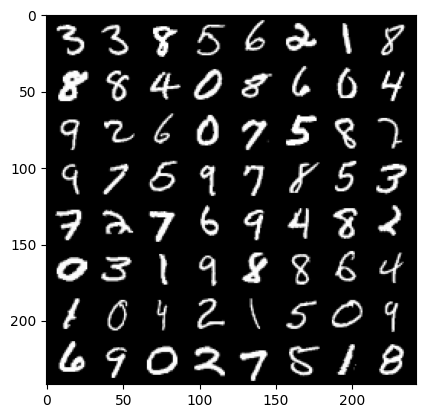

In [10]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

### Hyperparameters

In [11]:
!ls

checkpoints   GetData.ipynb  requirements.txt	 visualize.ipynb
data	      images	     residualDataset.py  vqvae.py
decompose.py  __pycache__    train.ipynb
documents     README.md      utils.py


In [12]:
from vqvae import VQVAE
from torch import nn, optim
import os
import utils

In [13]:
device = torch.device("cuda:0")
use_ema = True
epochs = 10
eval_every = 100
save_every = 5
if not os.path.isdir("checkpoints"):
    os.makedirs("checkpoints")
save_path = "checkpoints/save_3.pth"
resume_train = os.path.isfile(save_path)
lr = 3e-4
model_args = {
    "in_channels": 1,
    "out_channels": 1,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
beta = 0.25

In [14]:
# Load weights if applicable
if resume_train:
  lr, epoch, model_w, optimizer_w, model_args = load_weights(save_path, map_location=device)

# Initialize model.
model = VQVAE(**model_args).to(device)
train_params = [params for params in model.parameters()]
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

if resume_train:
  optimizer = optim.Adam(train_params, lr=lr)
  model.load_state_dict(model_w)
  optimizer.load_state_dict(optimizer_w)

### Training VAE

In [34]:
def trainVAE(epoch, model, criterion, optimizer, trainloader, testloader, variance, save_path, device):
  best_train_loss = float("inf")
  for epoch in range(epochs):
      model.train()
      total_train_loss = 0
      total_recon_error = 0
      n_train = 0
      for (batch_idx, train_tensors) in enumerate(trainloader):
          optimizer.zero_grad()
          imgs = train_tensors[0].to(device)
          out = model(imgs)
          recon_error = criterion(out["x_recon"], imgs) / variance
          total_recon_error += recon_error.item()
          loss = recon_error + beta * out["commitment_loss"]
          if not use_ema:
              loss += out["dictionary_loss"]

          total_train_loss += loss.item()
          loss.backward()
          optimizer.step()
          n_train += 1

          if ((batch_idx + 1) % eval_every) == 0:
              print(f"epoch: {epoch}\nbatch_idx: {batch_idx + 1}", flush=True)
              total_train_loss /= n_train
              if total_train_loss < best_train_loss:
                  best_train_loss = total_train_loss
                  save_dict = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr': lr,
                    'model_args': model_args
                  }
                  ssplit = os.path.splitext(save_path)
                  be_save = f"{ssplit[0]}_best{ssplit[1]}"
                  torch.save(save_dict, be_save)

              print(f"total_train_loss: {total_train_loss} | best_train_loss: {best_train_loss} | recon_error: {total_recon_error / n_train}\n")

              total_train_loss = 0
              total_recon_error = 0
              n_train = 0

      if(epoch % save_every == 0):
          save_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': lr,
            'model_args': model_args
          }
          ssplit = os.path.splitext(save_path)
          ep_save = f"{ssplit[0]}_{epoch}{ssplit[1]}"
          torch.save(save_dict, ep_save)

      # Evaluation
      model.eval()
      total_test_loss = 0
      total_test_recon_error = 0
      n_test = 0
      for (batch_idx, test_tensors) in enumerate(testloader):
          imgs = test_tensors[0].to(device)
          out = model(imgs)
          recon_error = criterion(out["x_recon"], imgs) / variance
          total_test_recon_error += recon_error.item()
          loss = recon_error + beta * out["commitment_loss"]
          total_test_loss += loss.item()
          n_test += 1
      print(f" total_test_loss: {total_test_loss} | recon_error: {total_test_recon_error / n_test}\n")


In [39]:
trainVAE(epochs, model, criterion, optimizer, trainloader, testloader, train_data_variance, save_path, device)

epoch: 0
batch_idx: 100
total_train_loss: 0.7228375658392906 | best_train_loss: 0.7228375658392906 | recon_error: 0.6760329043865204

epoch: 0
batch_idx: 200
total_train_loss: 0.2530871967971325 | best_train_loss: 0.2530871967971325 | recon_error: 0.20530326724052428

epoch: 0
batch_idx: 300
total_train_loss: 0.17160197407007216 | best_train_loss: 0.17160197407007216 | recon_error: 0.13096451155841352

epoch: 0
batch_idx: 400
total_train_loss: 0.1434916615486145 | best_train_loss: 0.1434916615486145 | recon_error: 0.10734588131308556

epoch: 0
batch_idx: 500
total_train_loss: 0.1266093384474516 | best_train_loss: 0.1266093384474516 | recon_error: 0.09276736363768577

epoch: 0
batch_idx: 600
total_train_loss: 0.11402118779718876 | best_train_loss: 0.11402118779718876 | recon_error: 0.08189398214221001

epoch: 0
batch_idx: 700
total_train_loss: 0.10561045683920384 | best_train_loss: 0.10561045683920384 | recon_error: 0.075240134075284

epoch: 0
batch_idx: 800
total_train_loss: 0.09813634

### Evaluation

In [40]:
!ls

checkpoints   GetData.ipynb  requirements.txt	 visualize.ipynb
data	      images	     residualDataset.py  vqvae.py
decompose.py  __pycache__    train.ipynb
documents     README.md      utils.py


In [41]:
from utils import save_img_tensors_as_grid

image_save_path = "images/"
if not os.path.isdir(image_save_path):
    os.makedirs(image_save_path)

true_file = os.path.join(image_save_path, "true.png")
recon_file = os.path.join(image_save_path, "recon.png")

model.eval()
with torch.no_grad():
    for valid_tensors in testloader:
        break

    save_img_tensors_as_grid(valid_tensors[0], 4, true_file)
    save_img_tensors_as_grid(model(valid_tensors[0].to(device))["x_recon"], 4, recon_file)

#### Reconstruction of Image Using Autoencoder For Residuals

In [16]:
!ls

checkpoints   GetData.ipynb  requirements.txt	 visualize.ipynb
data	      images	     residualDataset.py  vqvae.py
decompose.py  __pycache__    train.ipynb
documents     README.md      utils.py


In [17]:
from decompose import DecomposeVAE
from residualDataset import MNISTResidualDataset

In [30]:
# Load the image VAE
image_vae_path = "checkpoints/save_2_best.pth"
device = "cuda:0"

model_container = DecomposeVAE(weight_path=image_vae_path, device = "cpu") # this runs in the datsaet so should be on cpu
fullvae = model_container.getFullVAE()

In [31]:
BATCH_SIZE = 64

# Create the residual dataset
residual_train_dataset = MNISTResidualDataset(mnist_trainset, fullvae)
res_trainloader = torch.utils.data.DataLoader(residual_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

residual_test_dataset = MNISTResidualDataset(mnist_testset, fullvae)
res_testloader = torch.utils.data.DataLoader(residual_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [32]:
epochs = 10
res_save_path = "checkpoints/residual_save.pth"
resume_train = os.path.isfile(res_save_path)
lr = 3e-4
model_args = {
    "in_channels": 1,
    "out_channels": 1,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
beta = 0.25

# Load weights if applicable
if resume_train:
  lr, epoch, model_w, optimizer_w, model_args = load_weights(res_save_path, map_location=device)

# Initialize model.
model = VQVAE(**model_args).to(device)
train_params = [params for params in model.parameters()]
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

if resume_train:
  optimizer = optim.Adam(train_params, lr=lr)
  model.load_state_dict(model_w)
  optimizer.load_state_dict(optimizer_w)

In [35]:
trainVAE(epochs, model, criterion, optimizer, res_trainloader, res_testloader, 1, res_save_path, device)

epoch: 0
batch_idx: 100
total_train_loss: 0.0027145715116057545 | best_train_loss: 0.0027145715116057545 | recon_error: 0.0026837923796847463

epoch: 0
batch_idx: 200
total_train_loss: 0.0017968208412639797 | best_train_loss: 0.0017968208412639797 | recon_error: 0.0017862885259091854

epoch: 0
batch_idx: 300
total_train_loss: 0.0018559832172468304 | best_train_loss: 0.0017968208412639797 | recon_error: 0.0017067235393915326

epoch: 0
batch_idx: 400
total_train_loss: 0.0018755535595119 | best_train_loss: 0.0017968208412639797 | recon_error: 0.0016267613414674997

epoch: 0
batch_idx: 500
total_train_loss: 0.001978255788562819 | best_train_loss: 0.0017968208412639797 | recon_error: 0.0015337885939516126

epoch: 0
batch_idx: 600
total_train_loss: 0.0020230577792972326 | best_train_loss: 0.0017968208412639797 | recon_error: 0.0014243152423296123

epoch: 0
batch_idx: 700
total_train_loss: 0.002048826871905476 | best_train_loss: 0.0017968208412639797 | recon_error: 0.001343855122104287

epoch

KeyboardInterrupt: 

In [36]:
from utils import save_img_tensors_as_grid

image_save_path = "images/"
if not os.path.isdir(image_save_path):
    os.makedirs(image_save_path)

true_file = os.path.join(image_save_path, "res_image_true")
recon_file = os.path.join(image_save_path, "res_image_recon")

model.eval()
with torch.no_grad():
    for valid_tensors in testloader:
        break

    save_img_tensors_as_grid(valid_tensors[0], 4, true_file)
    save_img_tensors_as_grid(model(valid_tensors[0].to(device))["x_recon"], 4, recon_file)